## Running Sentiment Analysis and Restricted Boltzmann Machine-based Recommendation System on Beer Reviews
### I will be using a Recurrent Neural Network (RNN) and a Long Short-Term Memory (LSTM) model to run sentiment analysis based on the names of beers and a score based on reviews made by users. I will then be using a Restricted Boltzmann Machine model to create a recommendation system based on scores trained on the dataset. This system recommends beers to users that have a similar score based on existing reviews the user has made. This dataset was downloaded from https://www.kaggle.com/datasets/thedevastator/1-5-million-beer-reviews-from-beer-advocate.
### Deep Learning techniques used: RNN, LSTM, RBM, hyperparameter tuning
![title](pic/toast-beer-drinks-free-vector.jpg)

### Load necessary libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import re
import keras
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.models import Sequential
from nltk.corpus import stopwords
from string import punctuation
import warnings
warnings.filterwarnings("ignore")


### Exploratory Data Analysis

In [2]:
# Importing the data set
df = pd.read_csv('beer_reviews.csv')
df.head()

,index,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


In [3]:
# Get information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 14 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   index               1586614 non-null  int64  
 1   brewery_id          1586614 non-null  int64  
 2   brewery_name        1586599 non-null  object 
 3   review_time         1586614 non-null  int64  
 4   review_overall      1586614 non-null  float64
 5   review_aroma        1586614 non-null  float64
 6   review_appearance   1586614 non-null  float64
 7   review_profilename  1586266 non-null  object 
 8   beer_style          1586614 non-null  object 
 9   review_palate       1586614 non-null  float64
 10  review_taste        1586614 non-null  float64
 11  beer_name           1586614 non-null  object 
 12  beer_abv            1518829 non-null  float64
 13  beer_beerid         1586614 non-null  int64  
dtypes: float64(6), int64(4), object(4)
memory usage: 169.5+ MB


In [4]:
# Print the keys used in the dataframe
print(df.keys())

Index(['index', 'brewery_id', 'brewery_name', 'review_time', 'review_overall',
       'review_aroma', 'review_appearance', 'review_profilename', 'beer_style',
       'review_palate', 'review_taste', 'beer_name', 'beer_abv',
       'beer_beerid'],
      dtype='object')


In [5]:
# Describe the DataFrame
print(df.describe())

              index    brewery_id   review_time  review_overall  review_aroma  \
count  1.586614e+06  1.586614e+06  1.586614e+06    1.586614e+06  1.586614e+06   
mean   7.933065e+05  3.130099e+03  1.224089e+09    3.815581e+00  3.735636e+00   
std    4.580162e+05  5.578104e+03  7.654427e+07    7.206219e-01  6.976167e-01   
min    0.000000e+00  1.000000e+00  8.406720e+08    0.000000e+00  1.000000e+00   
25%    3.966532e+05  1.430000e+02  1.173224e+09    3.500000e+00  3.500000e+00   
50%    7.933065e+05  4.290000e+02  1.239203e+09    4.000000e+00  4.000000e+00   
75%    1.189960e+06  2.372000e+03  1.288568e+09    4.500000e+00  4.000000e+00   
max    1.586613e+06  2.800300e+04  1.326285e+09    5.000000e+00  5.000000e+00   

       review_appearance  review_palate  review_taste      beer_abv  \
count       1.586614e+06   1.586614e+06  1.586614e+06  1.518829e+06   
mean        3.841642e+00   3.743701e+00  3.792860e+00  7.042387e+00   
std         6.160928e-01   6.822184e-01  7.319696e-01  2.

In [6]:
# Grabbing the columns that we need 
df_reviews = df[['review_overall','beer_style','review_profilename', 'beer_name']]

In [7]:
# Display the head of the new dataframe
df_reviews.head()

,review_overall,beer_style,review_profilename,beer_name
0,1.5,Hefeweizen,stcules,Sausa Weizen
1,3.0,English Strong Ale,stcules,Red Moon
2,3.0,Foreign / Export Stout,stcules,Black Horse Black Beer
3,3.0,German Pilsener,stcules,Sausa Pils
4,4.0,American Double / Imperial IPA,johnmichaelsen,Cauldron DIPA


In [8]:
# Loading the top 10 reviewers with the most reviews
df.pivot_table(columns=['review_profilename'], aggfunc='size').sort_values(ascending=False).head(10)

review_profilename
northyorksammy    5817
BuckeyeNation     4661
mikesgroove       4617
Thorpe429         3518
womencantsail     3497
NeroFiddled       3488
ChainGangGuy      3471
brentk56          3357
Phyl21ca          3179
WesWes            3168
dtype: int64

In [9]:
# Creating a new dataframe grouped by beer names
popular = df[['beer_name','review_profilename']].groupby('beer_name').count().sort_values(['review_profilename'], ascending=False).reset_index()

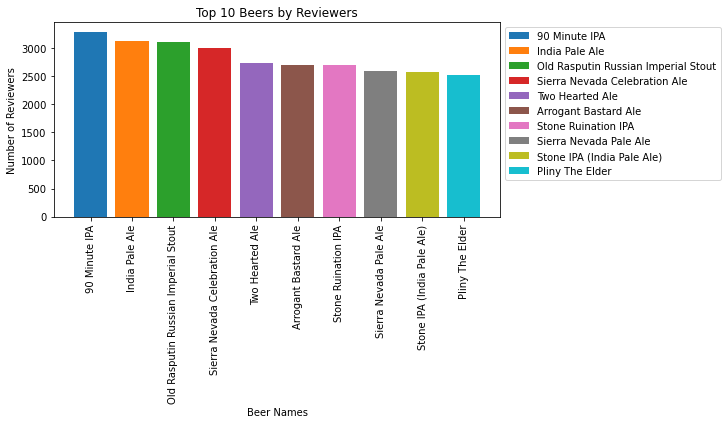

In [10]:
# Get the top 10 beer names with most reviewers
top_10_beers = popular.head(10)

# Create a list of colors
colors = plt.cm.tab10(np.arange(len(top_10_beers)))

# Create a bar graph with different colors for each bar
plt.figure(figsize=(10, 6))
bars = plt.bar(top_10_beers['beer_name'], top_10_beers['review_profilename'], color=colors)
plt.xlabel('Beer Names')
plt.ylabel('Number of Reviewers')
plt.title('Top 10 Beers by Reviewers')
plt.xticks(rotation=90)
plt.tight_layout()

# Adding a legend with beer names and colors outside the graph
plt.legend(bars, top_10_beers['beer_name'], loc='upper left', bbox_to_anchor=(1, 1))
plt.subplots_adjust(right=0.7)  # Adjust the space to accommodate the legend
plt.show()

In [11]:
# Filtering all the reviews made by user stcules
df_reviews[df_reviews['review_profilename']=='stcules']

,review_overall,beer_style,review_profilename,beer_name
0,1.5,Hefeweizen,stcules,Sausa Weizen
1,3.0,English Strong Ale,stcules,Red Moon
2,3.0,Foreign / Export Stout,stcules,Black Horse Black Beer
3,3.0,German Pilsener,stcules,Sausa Pils
1551,4.0,Munich Dunkel Lager,stcules,Kollers Naturtrüb Dunkel
...,...,...,...,...
1584791,4.0,Oatmeal Stout,stcules,Black Mamba
1584792,4.0,Belgian Pale Ale,stcules,Ley Line
1586165,2.0,Bock,stcules,Vølenbock
1586297,3.5,Munich Dunkel Lager,stcules,Lasser Dunkel


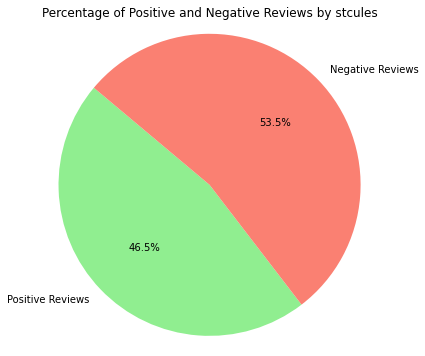

In [12]:
# Filter reviews made by user 'stcules'
user_reviews = df_reviews[df_reviews['review_profilename'] == 'stcules']

# Define the thresholds for positive and negative reviews
positive_threshold = 3

# Calculate the counts of positive and negative reviews
positive_reviews = user_reviews[user_reviews['review_overall'] > positive_threshold]
negative_reviews = user_reviews[user_reviews['review_overall'] <= positive_threshold]

# Calculate the percentages
total_reviews = len(user_reviews)
percentage_positive = len(positive_reviews) / total_reviews * 100
percentage_negative = len(negative_reviews) / total_reviews * 100

# Plotting the percentages
labels = ['Positive Reviews', 'Negative Reviews']
sizes = [percentage_positive, percentage_negative]
colors = ['lightgreen', 'salmon']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Positive and Negative Reviews by stcules')
plt.axis('equal')
plt.show()

<h3> Plotting the Total Reviews</h3>

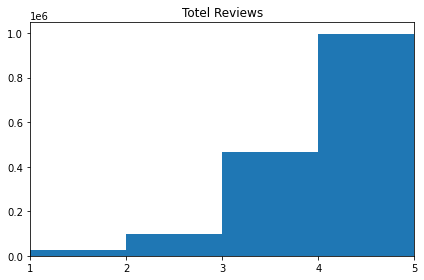

In [13]:
fig, axs = plt.subplots(sharey=True, tight_layout=True)
axs.hist(df_reviews['review_overall'],bins=5)
plt.xlim([1, 5])
plt.xticks(np.arange(1, 6, 1))
plt.title('Totel Reviews')
plt.show()

<h3>Changing the Scores into Positive and Negative Values</h3>

In [14]:
df_reviews['Polarity_Rating'] = df_reviews['review_overall'].apply(lambda x: 'Positive' if x > 3.0 else 'Negative')

<AxesSubplot:xlabel='Polarity_Rating', ylabel='count'>

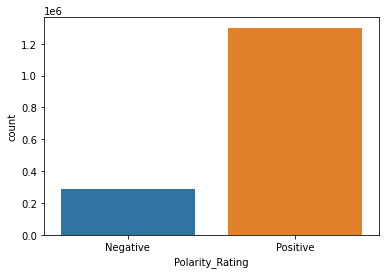

In [15]:
# Plotting the ratio of positive and negative reviews
sns.countplot(data = df_reviews, x= 'Polarity_Rating')

In [16]:
# Showing the total number of reviews based on how many positive and negative reviews there are
polarity_counts = df_reviews['Polarity_Rating'].value_counts()
print(polarity_counts)

Positive    1300286
Negative     286328
Name: Polarity_Rating, dtype: int64


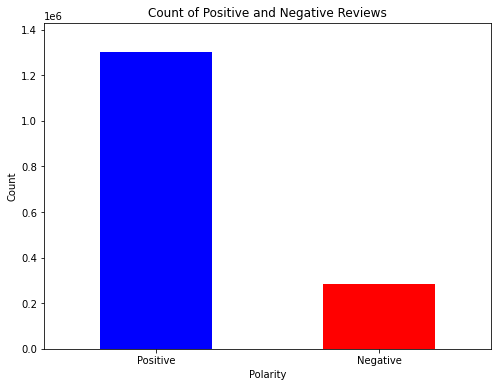

In [17]:
# Plotting the count of positive and negative reviews
plt.figure(figsize=(8, 6))
polarity_counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Count of Positive and Negative Reviews')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Displaying raw counts on y-axis
plt.ylim(0, max(polarity_counts) * 1.1)  # Set y-axis limit slightly higher than the maximum count
plt.yticks(range(0, max(polarity_counts) + 100000, 200000))  # Adjust y-tick marks to suit the count range

plt.show()

<h3>We see there are many more positive reviews than negative reviews, so we will take just a sample of these reviews to run our model on. In this case, we will take a sample of 5000 positive and negative reviews</h3>

In [18]:
df_reviews[df_reviews['Polarity_Rating'] == 'Negative'].shape[0]

286328

In [19]:
# Filter positive and negative reviews separately
positive_reviews = df_reviews[df_reviews['Polarity_Rating'] == 'Positive']
negative_reviews = df_reviews[df_reviews['Polarity_Rating'] == 'Negative']

# Take a random sample of 5000 from each category
positive_sample = positive_reviews.sample(n=5000, random_state=42)
negative_sample = negative_reviews.sample(n=5000, random_state=42)

# Concatenate the samples
sampled_reviews = pd.concat([positive_sample, negative_sample])

# Select columns of interest (names of beers and review text)
sampled_data = sampled_reviews[['beer_name', 'review_overall', 'Polarity_Rating']]

# Reset the index of the new DataFrame
sampled_data.reset_index(drop=True, inplace=True)

In [20]:
# Setting the stop words in case these show up in the beer names
english_stops = set(stopwords.words('english'))

<h3>Cleaning and splitting the data into beer names and polarity ratings</h3>

In [21]:
x_data = sampled_data['beer_name']  # Input: beer names
y_data = sampled_data['Polarity_Rating']  # Output: Sentiment labels

# ENCODE SENTIMENT -> 0 & 1
y_data = y_data.replace('Positive', 1)
y_data = y_data.replace('Negative', 0)

<h3>Splitting the dataset for training</h3>

In [22]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

<h3>Making a function to get the max length for padding</h3>

In [23]:
# Define a function named 'get_max_length' that takes 'x_train' as input
def get_max_length(x_train):
    # Create a list 'review_length' containing the length of each review after splitting by words
    review_length = [len(review.split()) for review in x_train]
    
    # Calculate the mean (average) length of reviews and round it up to the nearest integer
    # 'np.mean' calculates the mean of the list 'review_length'
    # 'np.ceil' rounds the result up to the nearest integer
    return int(np.ceil(np.mean(review_length)))

# Call the 'get_max_length' function passing 'X_train' as an argument and store the result in 'max_length'
max_length = get_max_length(X_train)

# Print the calculated maximum length of reviews
print(max_length)

4


<h3>Loading the Tokenizer to convert the words into sequences and then add the padding to make the rows equal lenght.</h3>

In [24]:
# Encode beer name
token = Tokenizer(lower=False)  # Initialize a Tokenizer object with 'lower=False' to preserve case sensitivity
token.fit_on_texts(X_train)    # Fit the tokenizer on the training data
x_train = token.texts_to_sequences(X_train)  # Convert text in training data to sequences
x_test = token.texts_to_sequences(X_test)    # Convert text in testing data to sequences

# Apply padding to the sequences in the training data
x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')

# Apply padding to the sequences in the testing data
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

# Calculate the total number of unique words in the tokenizer's word index and add 1 for padding
total_words = len(token.word_index) + 1


<h3>Building the RNN with LSTM Model </h3>

In [25]:
# ARCHITECTURE
EMBED_DIM = 3200  # Define the embedding dimension
LSTM_OUT = 64     # Define the number of LSTM units

model = Sequential()  # Initialize a Sequential model

# Add an Embedding layer to the model
# Embedding layer maps words to dense vectors of fixed size
# total_words: Total number of unique words in the vocabulary
# EMBED_DIM: Dimension of the dense embedding
# input_length: Length of input sequences (number of words in each sequence)
model.add(Embedding(total_words, EMBED_DIM, input_length=max_length))

# Add an LSTM layer to the model
# LSTM layer with LSTM_OUT units (number of memory cells)
model.add(LSTM(LSTM_OUT))

# Add a Dense layer with a single output unit and sigmoid activation
# Sigmoid activation is used for binary classification tasks
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model with 'adam' optimizer, 'binary_crossentropy' loss function, and accuracy metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Adding a Checkpoint to save the model when the accuracy improves
# ModelCheckpoint saves the model with the best accuracy during training
checkpoint = ModelCheckpoint('models/LSTM.h5', monitor='accuracy', save_best_only=True, verbose=1)

<h3>Showing a summary of the model</h3>

In [26]:
# Show a summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 3200)           13872000  
                                                                 
 lstm (LSTM)                 (None, 64)                835840    
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 14,707,905
Trainable params: 14,707,905
Non-trainable params: 0
_________________________________________________________________


<h3>Fitting the model</h3>

In [27]:
history = model.fit(x_train, y_train, epochs=10, batch_size=20, callbacks= [checkpoint],validation_data=(x_test, y_test))

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 0.6605 - accuracy: 0.5985
Epoch 00001: accuracy improved from -inf to 0.59850, saving model to models\LSTM.h5
400/400 [==============================] - 33s 81ms/step - loss: 0.6605 - accuracy: 0.5985 - val_loss: 0.6426 - val_accuracy: 0.6275
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.5329 - accuracy: 0.7404
Epoch 00002: accuracy improved from 0.59850 to 0.74037, saving model to models\LSTM.h5
400/400 [==============================] - 33s 83ms/step - loss: 0.5329 - accuracy: 0.7404 - val_loss: 0.6905 - val_accuracy: 0.6010
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 0.4376 - accuracy: 0.7885
Epoch 00003: accuracy improved from 0.74037 to 0.78850, saving model to models\LSTM.h5
400/400 [==============================] - 33s 83ms/step - loss: 0.4376 - accuracy: 0.7885 - val_loss: 0.7936 - val_accuracy: 0.5960
Epoch 4/10
400/400 [==============================] - E

<h3>Plotting the loss</h3>

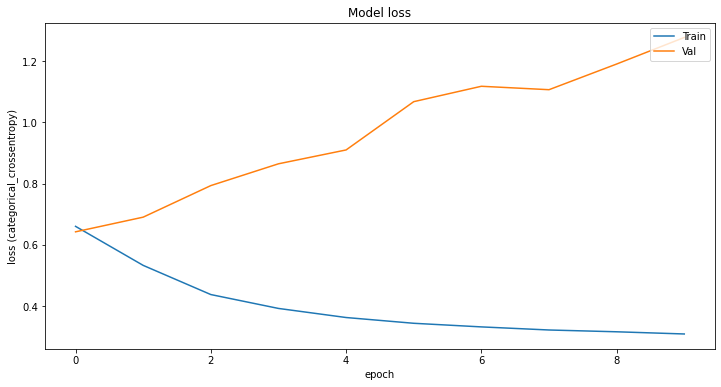

In [28]:
plt.figure(figsize=(12,6))
plt.plot(model.history.history['loss'][:])
plt.plot(model.history.history['val_loss'][:])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss (categorical_crossentropy)')
plt.legend(['Train', 'Val'], loc='upper right')

<h3>Plotting the accuracy</h3>

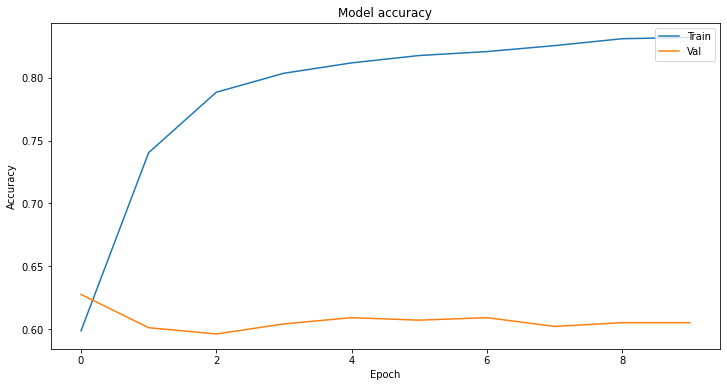

In [29]:
plt.figure(figsize=(12,6))
plt.plot(model.history.history['accuracy'][:])
plt.plot(model.history.history['val_accuracy'][:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

<h3>Testing the model</h3>

In [30]:
#I grab a random review from the dataframe
value = 200
df_reviews.iloc[value]

review_overall                            4.5
beer_style            American Pale Ale (APA)
review_profilename               indiapaleale
beer_name                    Caldera Pale Ale
Polarity_Rating                      Positive
Name: 200, dtype: object

In [31]:
df_reviews.iloc[value]['beer_name']

'Caldera Pale Ale'

<h3>Cleaning the data before loading it to the model for prediction</h3>

In [32]:
# Accessing the 'beer_name' column of the DataFrame at index 'value'
review = df_reviews.iloc[value]['beer_name']

# Compile a regular expression to remove non-alphabetic characters and spaces
regex = re.compile(r'[^a-zA-Z\s]')

# Apply the regular expression substitution to remove non-alphabetic characters
review = regex.sub('', review)

# Split the 'review' text into a list of words
words = review.split(' ')

# Filtering out words that are in the 'english_stops' list (stopwords)
filtered = [w for w in words if w not in english_stops]

# Joining the filtered words back into a single string
filtered = ' '.join(filtered)

# Converting the filtered text to lowercase and storing it as a list
filtered = [filtered.lower()]

<h3>Tokenize and encode the words so they can be loaded into the model for prediction</h3>

In [33]:
# Tokenizing the filtered text using the Tokenizer's texts_to_sequences method
tokenize_words = token.texts_to_sequences(filtered)

# Padding the tokenized sequences to a fixed length (max_length)
# 'post' padding adds zeros at the end if the sequence is shorter than max_length
# 'truncating='post'' truncates sequences longer than max_length from the end
tokenize_words = pad_sequences(tokenize_words, maxlen=max_length, padding='post', truncating='post')

In [34]:
# Making predictions on tokenized and padded words using the trained model
result = model.predict(tokenize_words)

# Checking the predicted result probability and classifying as Positive or Negative
if result >= 0.50:
    print('Positive')
else:
    print('Negative')

Negative


<h3>Preparing to train the model for recommedation </h3>

In [35]:
# Making unique numeric IDs for all the users
df_reviews['UserID'] = pd.factorize(df_reviews['review_profilename'])[0] + 1

In [36]:
df_reviews[df_reviews['UserID'] == 42].head()

,review_overall,beer_style,review_profilename,beer_name,Polarity_Rating,UserID
45,3.5,Rauchbier,beagle75,Rauch Ür Bock,Positive,42
691,4.0,American IPA,beagle75,Caldera IPA,Positive,42
756,3.5,American IPA,beagle75,Hopportunity Knocks,Positive,42
907,4.5,American Porter,beagle75,Mogli,Positive,42
2894,2.0,American Double / Imperial IPA,beagle75,Hop Dam Triple IPA,Negative,42


In [37]:
# Cleaning the dataset more to remove duplicate reviews
cleaned = df_reviews.drop_duplicates(subset=['UserID'], keep='last')

print('Removed Dulipcated, Total Reviews {}'.format(cleaned.shape[0]))
print('Total Reviews {}'.format(df_reviews.shape[0]))

Removed Dulipcated, Total Reviews 33388
Total Reviews 1586614


In [38]:
# Show the cleaned dataset head
cleaned.head()

,review_overall,beer_style,review_profilename,beer_name,Polarity_Rating,UserID
43,4.0,Rauchbier,Mattybeerguy,Rauch Ür Bock,Positive,40
331,4.0,American Blonde Ale,brianairb85,Caldera Rose Petal (Kettle Series),Positive,262
341,4.5,American IPA,alabamatie,Caldera IPA,Positive,268
350,3.0,Euro Pale Lager,kww,Amstel Bright,Negative,275
466,4.0,American IPA,PeteVenkman,Caldera IPA,Positive,359


In [39]:
user_rating_df = cleaned.pivot(index='UserID', columns='beer_name', values='review_overall')

In [40]:
user_rating_df.head(5)

beer_name,"""M""-perial Stout","""Shabadoo"" Black & Tan Ale",#9,'Pooya Porter,'t Gaverhopke Extra,'t Smisje Blond,'t Smisje Dubbel,'t Smisje Halloween,'t Smisje IPA+,(512) Black IPA,...,"Åbro Kung 5,2%",Ægir Sumbel Porter,Édition 2005,Éphémère (Apple),Éphémère (Cassis / Black Currant),Érable Rouge,Ølfabrikken Brown Ale,Ølfabrikken Kloster Jul,Über Oktolager,ÜberSun (Imperial Summer Wheat Beer)
UserID,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h3>Normalizing the data</h3>

In [41]:
# Disable TensorFlow's eager execution mode (used in TensorFlow 2.x to execute operations immediately)
tf.compat.v1.disable_eager_execution()

# Normalize user rating DataFrame by filling missing values with 0 and scaling to a range of 0 to 1
norm_user_rating_df = user_rating_df.fillna(0) / 5.0

# Extract the values (as a NumPy array) from the normalized DataFrame, representing training data
trX = norm_user_rating_df.values

# Display the first 5 rows of the extracted training data
trX[0:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<h3>Define parameters and placeholders</h3>

In [42]:
# Set the number of units for visible and hidden layers in the RBM
hiddenUnits = 20
visibleUnits =  len(user_rating_df.columns)
vb = tf.compat.v1.placeholder("float", [visibleUnits])
hb = tf.compat.v1.placeholder("float", [hiddenUnits])
W = tf.compat.v1.placeholder("float", [visibleUnits, hiddenUnits])

# Define placeholders for visible bias, hidden bias, and weights
v0 = tf.compat.v1.placeholder("float", [None, visibleUnits])  # Placeholder for visible layer at phase 0
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)  # Compute probabilities of hidden units given visible units at phase 0
h0 = tf.nn.relu(tf.sign(_h0 - tf.random.uniform(tf.shape(input=_h0))))  # Compute hidden units at phase 0

# Define placeholders for input data during RBM training
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) # Compute probabilities of visible units given hidden units at phase 1
v1 = tf.nn.relu(tf.sign(_v1 - tf.random.uniform(tf.shape(input=_v1)))) # Compute visible units at phase 1
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb) # Compute probabilities of hidden units given visible units at phase 1

# Define learning rate and calculate gradients for weight updates
alpha = 1.0

w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)

CD = (w_pos_grad - w_neg_grad) / tf.compat.v1.to_float(tf.shape(v0)[0])

update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

err = v0 - v1
err_sum = tf.reduce_mean(err * err)

# Initialize variables for weights, biases, and errors
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

cur_vb = np.zeros([visibleUnits], np.float32)

cur_hb = np.zeros([hiddenUnits], np.float32)

prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

prv_vb = np.zeros([visibleUnits], np.float32)

prv_hb = np.zeros([hiddenUnits], np.float32)


# Initialize TensorFlow session and variables
sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())


# Train the RBM using for loops and batch processing
epochs = 10
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print (errors[-1])

Instructions for updating:
Use `tf.cast` instead.
0.002944456
0.0014314236
0.0009296867
0.0006889678
0.0005620517
0.0004774128
0.0004241281
0.00039111968
0.000361214
0.0003377176


<h3>Plotting the errors over the epochs</h3>

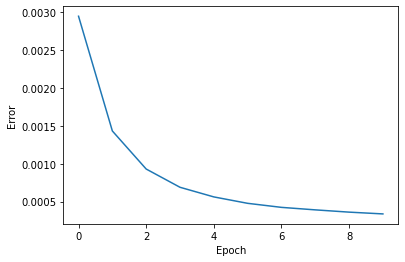

In [43]:
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

<h3>Selecting a mock user to test the recommendation system on</h3>

In [44]:
# Selecting a user
mock_user_id = 42

In [45]:
# Selecting the input user
inputUser = trX[mock_user_id-1].reshape(1, -1)
inputUser[0:5]

array([[0., 0., 0., ..., 0., 0., 0.]])

<h3>Getting the scores and recommendations for the system</h3>

In [46]:
# Feeding in the user input and reconstructing the input using the RBM weights and biases

# Calculate the hidden layer probabilities given the user input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)

# Reconstruct the visible layer probabilities given the calculated hidden layer probabilities
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)

# Feed the user input through the hidden layer to get the hidden layer activation
feed = sess.run(hh0, feed_dict={v0: inputUser, W: prv_w, hb: prv_hb})

# Reconstruct the input based on the hidden layer activation obtained above
rec = sess.run(vv1, feed_dict={hh0: feed, W: prv_w, vb: prv_vb})


<h3>We will now use the system to recommend beers to our mock user</h3>

In [47]:
scored_asin_df_mock = cleaned.drop_duplicates(subset=['beer_name'])
scored_asin_df_mock = scored_asin_df_mock.assign(RecommendationScore = rec[0])
scored_asin_df_mock[['beer_name','RecommendationScore']].sort_values(["RecommendationScore"], ascending=False).head(20)

,beer_name,RecommendationScore
1562771,Idaho Pale Ale,0.015795
1586276,Mighty Oak Burntwood Bitter,0.014452
920807,Red Hill Wheat Beer,0.011883
1586102,Coldstream Pilsner,0.010269
1493162,Telemark India Pale Ale (I.P.A.),0.008945
412459,Killellan Bitter,0.008816
1246722,"Ramée Blonde (for Bibco, Ternat)",0.007996
1473233,Church Key West Coast Pale Ale,0.007193
1536245,Revalations Stout,0.006623
1325367,Wachusett Country Pale Ale,0.006159


In [48]:
beer_df_mock = cleaned[cleaned['UserID'] == 42]
beer_df_mock.head()

,review_overall,beer_style,review_profilename,beer_name,Polarity_Rating,UserID
1585991,3.5,American Pale Ale (APA),beagle75,Drake's 1500 Pale Ale,Positive,42


In [49]:
# Merging movies_df with ratings_df by beer_name
merged_df_mock = scored_asin_df_mock.merge(beer_df_mock, on='beer_name', how='outer')

<h3> These will be the top five beers that the system will recommend to our mock user based on our defined system</h3>

In [50]:
merged_df_mock[['beer_name','RecommendationScore']].sort_values(["RecommendationScore"], ascending=False).head(5)

,beer_name,RecommendationScore
6717,Idaho Pale Ale,0.015795
7249,Mighty Oak Burntwood Bitter,0.014452
3170,Red Hill Wheat Beer,0.011883
7233,Coldstream Pilsner,0.010269
6326,Telemark India Pale Ale (I.P.A.),0.008945


### Summary and Conclusion
### The sentiment analysis running on the RNN model had an accuracy of roughly 83% after running on 10 epochs. In order to make the model fit the dataset, I took a random sample of 5000 positive and negative reviews, though this made the epochs take about half a minute to run. The model may have been more accurate if more than 10 epochs were used to train the model, so tuning the hyperparameters may have improved the accuracy of the sentiment analysis model. The recommendation system based on a Restricted Boltzmann Machine model seems to work well. The recommendations made based on the recommendation score appears to be accurate, so this can be used to recommend beers to users who have not created a review on them yet.